In [2]:

import librosa
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
train=np.load("./drive/My Drive/audio_train.npy")
test=np.load("./drive/My Drive/audio_test.npy")
train_labels=pd.read_csv("./drive/My Drive/labels_train.csv")
sample_submission=pd.read_csv("./drive/My Drive/sample_submission.csv")
label = list(train_labels['label'])

y_train = np.empty([len(train),1])
for i in range(len(label)):
  y_train[i] = label[i]
y_train = np.array(y_train, dtype='uint8')

num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)

Mounted at /content/drive


In [3]:

trainImage = np.empty([len(train),128,59,1])
for i in range(len(train)):
  trainImage[i] = np.expand_dims(librosa.feature.melspectrogram(y=train[i], sr=22050),axis=2)


In [4]:

testImage = np.empty([len(test),128,59,1])
for i in range(len(test)):
  testImage[i] = np.expand_dims(librosa.feature.melspectrogram(y=test[i], sr=22050),axis=2)

In [5]:
squareImage = np.empty([len(train),128,128,1])
for i in range(len(train)):
  squareImage[i] = tf.image.resize_with_pad(trainImage[i], 128, 128,antialias=False)


In [6]:
squareTestImage = np.empty([len(test),128,128,1])
for i in range(len(test)):
  squareTestImage[i] = tf.image.resize_with_pad(testImage[i], 128, 128,antialias=False)



In [7]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(128, 128, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=32*32*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(32, 32, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [8]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [9]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 50
num_examples_to_generate = 50

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [19]:
def generate_and_save_images(model, epoch, squareTestImage):
  mean, logvar = model.encode(squareTestImage)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(25, 25, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [20]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

NameError: ignored

In [22]:
import time

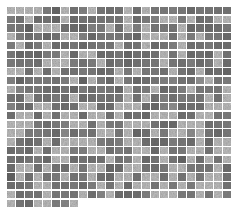

ValueError: ignored

In [25]:
generate_and_save_images(model, 0, squareTestImage)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  train_step(model, squareImage.astype("float32"), optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  loss(compute_loss(model, squareTestImage))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

In [28]:
import tensorflow_probability as tfp

In [29]:
def plot_latent_images(model, n, digit_size=128):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

In [33]:
plot_latent_images(model, 20)

ValueError: ignored